In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV

# cluster functions
empty = [0]
point = [1,2]
pair_1 = [3,4]
pair_2 = [5,6,7]
pair_3 = [8,9,10,11]
pair_4 = [12,13,14,15]
triplet_1 = [16,17]
#triplet_2 = [18,19,20,21]

def select_cluster(df_corr, clusters):
    clus = []
    for i in clusters:
        clus = clus + i
    clus = np.array(clus)
    return df_corr.iloc[:,clus]

def regularize(df, grid_fine, smooth_width=0):
    df_fine = pd.DataFrame(index=df.index, columns=['configname', 'energy', 'abs_coef', 'ahv', 'gap'])
    for i in df.index:
        abs_coef = df.loc[i, "abs_coef"]
        ahv = df.loc[i, "ahv"]
        grid_coarse = df.loc[i, "energy"]
        #if smooth_width > 0:
        #    box = np.ones(smooth_width)/smooth_width
        #    abs_coef = np.convolve(dos, box, mode='same')
        f = interpolate.interp1d(grid_coarse,abs_coef)
        df_fine.loc[i,"abs_coef"] = f(grid_fine)
        f = interpolate.interp1d(grid_coarse,ahv)
        df_fine.loc[i,"ahv"] = f(grid_fine)
        df_fine.loc[i,"energy"] = grid_fine
        df_fine.loc[i,"gap"] = df.loc[i, "gap"]
        df_fine.loc[i,"configname"] = df.loc[i, "configname"]
    return df_fine

def weight(df_abs, gap_max, w_exp):
    w = np.exp((gap_max-df_abs.gap.values.astype(float))/w_exp)
    return w

def calc_model(corr,x, w):
    xx = np.concatenate(x.values)
    nabs = len(xx)/len(corr)
    xx = xx.reshape(len(corr), int(nabs))
    ridge = linear_model.Ridge(fit_intercept=False)
    alphas = np.logspace(-5, 1, 10)
    params = [{'alpha': alphas}]
    model = GridSearchCV(ridge, params, scoring='neg_mean_squared_error', cv=5, refit=True, return_train_score= True)
    model.fit(corr.values, xx)
    return model

def match(df_abs, df_corr):
    overlap = list(set(df_abs['configname']).intersection(set(df_corr['configname'])))
    if len(overlap) < len(df_abs['configname']):
        raise ValueError('Data and correlation data inconsistent.')
    df = pd.DataFrame()
    for i in df_abs['configname']:
        df = df.append(df_corr[df_corr['configname'] == i])
    return df

def calc_abs(df):
    df['abs_coef'] = np.nan
    df['abs_coef'] = df['abs_coef'].astype(object)
    df['ahv'] = np.nan
    df['ahv'] = df['ahv'].astype(object)
    for i in df.index:
        eps_r = df.loc[i].eps_r.mean(axis=1)
        eps_i = df.loc[i].eps_i.mean(axis=1)
        #
        eps_r = df.loc[i].eps_r[:,0]
        eps_i = df.loc[i].eps_i[:,0]
        #
        omega = df.loc[i].energy
        kappa = np.sqrt((np.sqrt(eps_r**2+eps_i**2) - eps_r)/2)
        abs_coef = 4*np.pi*omega*kappa*8065.5
        df.at[i, 'abs_coef'] = np.log(abs_coef)
        df.at[i, 'ahv'] = (abs_coef * omega)**2

def main(mat, clusters, gap_th=0.35, w_exp=0.1, verbose=False):
    global grid, df_abs, ref_ind
    #grid_fine = np.arange(2,8,0.02) # grid for the selected energy range
    # read corr matrix and electronic densities
    df_corr = pd.read_csv('corr_{0}.csv'.format(mat), delim_whitespace=True)
    df_abs = pd.read_hdf('ipa_{0}.h5'.format(mat))
    # semiconductors only    
    df_abs = df_abs[df_abs['configname'].str.contains('SCEL1|SCEL2|SCEL3')]
    semi = df_abs[(df_abs.gap > gap_th)].index
    df_abs = df_abs.loc[semi]
    df_corr = match(df_abs, df_corr)
    #assert (df_abs.index == df_corr.index).all(), "Index not aligned"
    df_corr = df_corr.set_index(df_abs.index)
    calc_abs(df_abs)
    energy_regular = np.linspace(0.2,1.0,81)
    df_abs = regularize(df_abs, energy_regular)
    #ref_ind = df_dos.gap.idxmax()
    if mat == 'czts':
        ref_ind = 1
    else:
        ref_ind = 0
    # interpolate the dos on a specific regular mesh
    #df_dos_fine = regularize_dos(df_dos, grid_fine, smooth_width=smooth_width, log=is_log)
    #
    # keep original mesh and data
    grid = df_abs.iloc[0]['energy']
    # define training set
    #train = df_corr.sample(frac=0.9, random_state=None)
    train = df_corr
    if ref_ind not in train.index:
        train = train.append(df_corr.loc[ref_ind])
    corr_train = train.loc[:,"corr(0)":"corr(17)"]
    abs_train = df_abs.loc[train.index,'abs_coef']
    ahv_train = df_abs.loc[train.index,'ahv']
    #
    corr_train = select_cluster(corr_train, clusters)
    #
    w = weight(df_abs.loc[train.index],df_abs.loc[ref_ind,'gap'],w_exp)
    if verbose:
        display(corr_train)
    model = calc_model(corr_train, abs_train, w)
    abs_train_pred = model.predict(corr_train)
    #print(model.best_estimator_.coef_[ind_vbm:ind_vbm+10].sum(axis=0))

    # plot the real abs coef. (gray) and the predicted ones (red)
    plt.rcParams['figure.figsize'] = [10,8]
    fig, (ax0) = plt.subplots(1,1)
    for i in range(len(abs_train)):
        ax0.plot(grid, np.exp(abs_train.iloc[i]), color='gray')
        ax0.plot(grid, np.exp(abs_train_pred[i]), color='r')
    ax0.set_xlim([0.2,1.0])
    ax0.set_ylim([0,1e4])
    ax0.set_title("Cluster expanded abs coef: Training set")
    ax0.set_ylabel(r"$\alpha$ (cm$^{-1}$)")
    # plot the eci vs energy
    fig, ax2 = plt.subplots(1)
    for i in range(len(model.best_estimator_.coef_[0,:])):
        ax2.plot(grid, model.best_estimator_.coef_[:,i], label=i)
    ax2.set_ylabel("Effective cluster abs coef.")
    ax2.set_xlim([0.2,1.0])
    ax2.legend()
    #
    return model

def ec_abs(mat,clusters,model):
    # plot abs coef. vs Temperature using the correlation matrix from MC simulations
    df_mc = pd.read_csv('mc_{0}.csv'.format(mat), delim_whitespace=True)
    df_mc = df_mc[df_mc['T'] <= 1000].reset_index()
    corr_str = []
    for i in range(18):
        corr_str.append("<corr({0:})>".format(i))
    df_corr_mc = df_mc.loc[:,corr_str]
    corr_mc = select_cluster(df_corr_mc, clusters)
    corr_mc = corr_mc.set_index(df_mc['T']).sort_index(ascending=False) # use temperature as index
    abs_mc_pred = model.predict(corr_mc)
    # cluster decomposed contribution
    _eci = model.best_estimator_.coef_.T
    _corr = corr_mc.values
    _ecabs = np.zeros(len(_corr.T))
    corr_fraction = np.zeros((len(model.best_estimator_.coef_),)+corr_mc.shape)
    for i in range(len(corr_fraction)): # energy
        for j in range(len(_corr)):     # temperature
            for k in range(len(_corr.T)): # corr
                _ecabs[k] = _corr[j,k]*_eci[k,i]
            corr_fraction[i,j] = _ecabs
    #
    plt.rcParams['figure.figsize'] = [10, 6]
    fig, ax0 = plt.subplots(1)
    norm = mpl.colors.Normalize(vmin=corr_mc.index.min(), vmax = corr_mc.index.max())
    cmap = mpl.cm.get_cmap('jet')
    c = [cmap(norm(temp)) for temp in corr_mc.index]
    ax0.set_xlim([0.2, 1.0])
    ax0.set_ylim([5e2, 1e5])
    grid_ = grid
    for i in range(len(abs_mc_pred)):
        ax0.plot(grid_, np.exp(abs_mc_pred[i]), color=c[i])
    cax, _ = mpl.colorbar.make_axes(ax0)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
    # plot the kesterite reference abs coef.
    ax0.plot(grid_, np.exp(df_abs.loc[ref_ind, "abs_coef"]), '--', c='k', label='reference at LT')
    ax0.set_xlabel(r'Energy (eV)')
    ax0.set_ylabel(r'$\alpha$ (cm$^{-1}$)')
    ax0.set_yscale('log')
    ax0.legend()
    #
    plt.rcParams['figure.figsize'] = [12, 8]
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
    for i in range(len(abs_mc_pred)):
        ax1.plot(grid_, np.exp(corr_fraction[:,i,1:3].sum(axis=1)), color=c[i])
        ax2.plot(grid_, np.exp(corr_fraction[:,i,3:5].sum(axis=1)), color=c[i])
        ax3.plot(grid_, np.exp(corr_fraction[:,i,5:8].sum(axis=1)), color=c[i])
        ax4.plot(grid_, np.exp(corr_fraction[:,i,8:].sum(axis=1)), color=c[i])
    for _ax in [ax1,ax2,ax3,ax4]:
        _ax.set_ylim([-1e4,1e4])
        _ax.set_xlim([0, 1.0])
        #cax, _ = mpl.colorbar.make_axes(_ax)
        #cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
    # tauc plot
    plt.rcParams['figure.figsize'] = [10, 6]
    fig, (ax) = plt.subplots(1)
    norm = mpl.colors.Normalize(vmin=corr_mc.index.min(), vmax = corr_mc.index.max())
    cmap = mpl.cm.get_cmap('jet')
    c = [cmap(norm(temp)) for temp in corr_mc.index]
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 5e8])
    grid_ = grid
    for i in range(len(abs_mc_pred)):
        ax.plot(grid_, np.exp(abs_mc_pred[i])**2*grid_**2, color=c[i])
    cax, _ = mpl.colorbar.make_axes(ax)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
    # plot the kesterite reference tauc
    ax.plot(grid_, df_abs.loc[ref_ind, "ahv"], '--', c='k', label='reference at LT')
    ax.set_xlabel(r'Energy (eV)')
    ax.set_ylabel(r"$(\alpha h \nu)^2$ (eV$^{2}$cm$^{-2}$)")
    ax.legend()
    #
    return corr_fraction, corr_mc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log


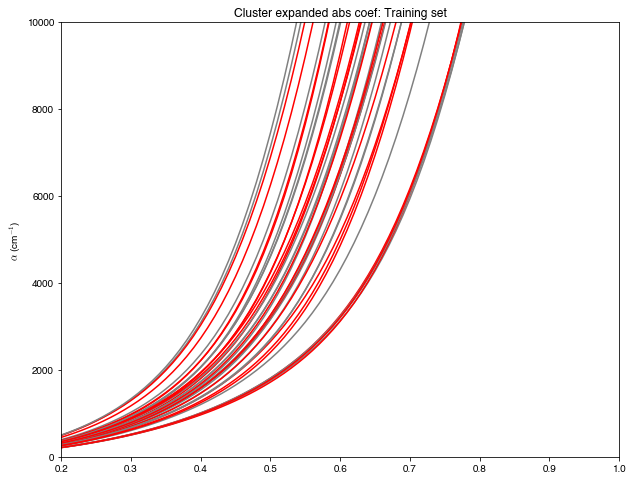

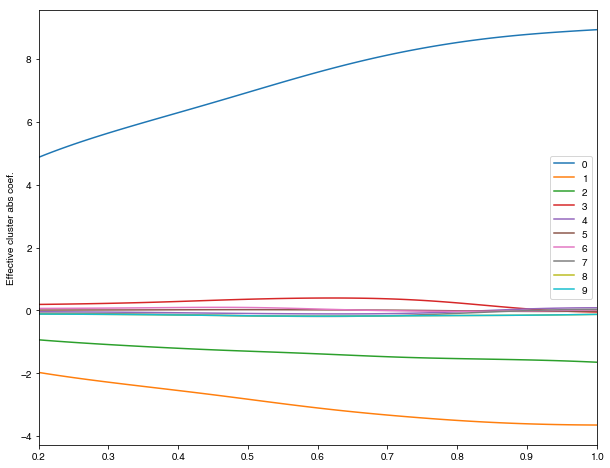

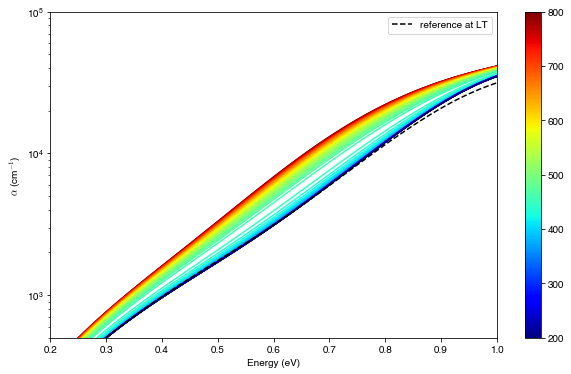

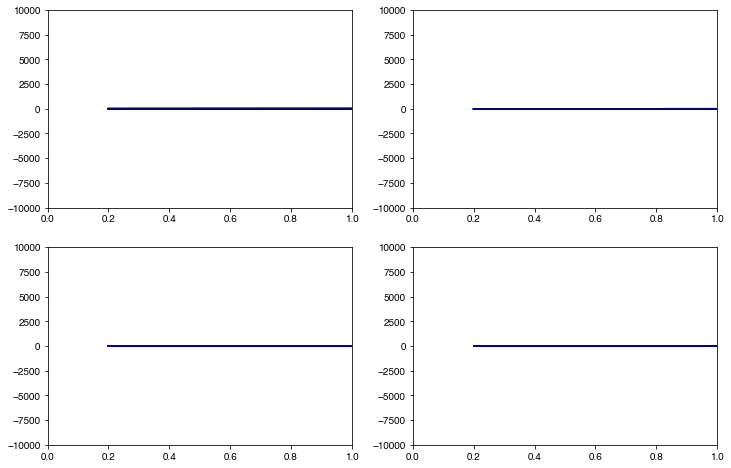

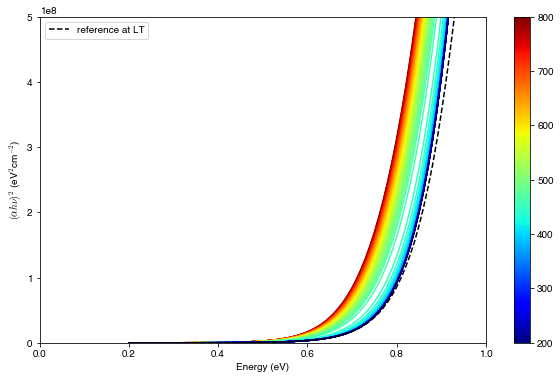

In [3]:
clusters = [empty, point, pair_1, pair_2, triplet_1]
model_czts = main("czts", clusters, gap_th=0.35, w_exp=10, verbose=False)
corr_fraction, corr_mc = ec_abs("czts",clusters,model_czts)

In [4]:
(-model_czts.best_score_)**0.5

0.1474466618938684

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


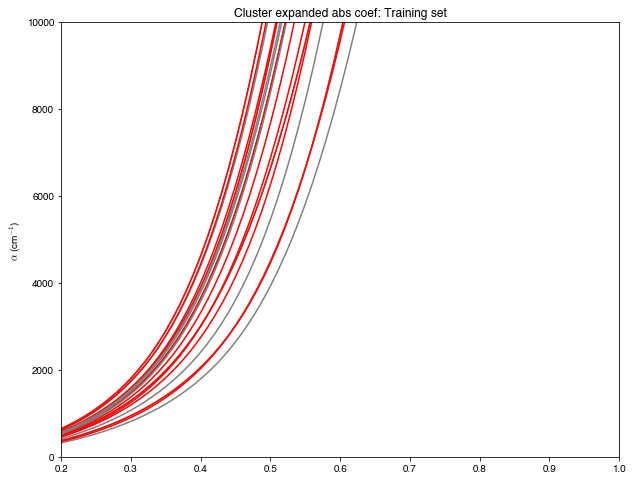

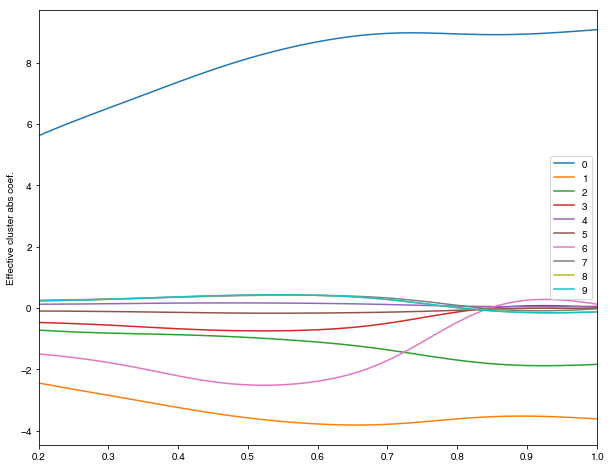

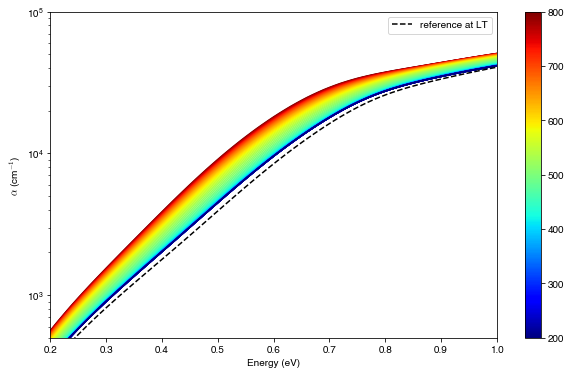

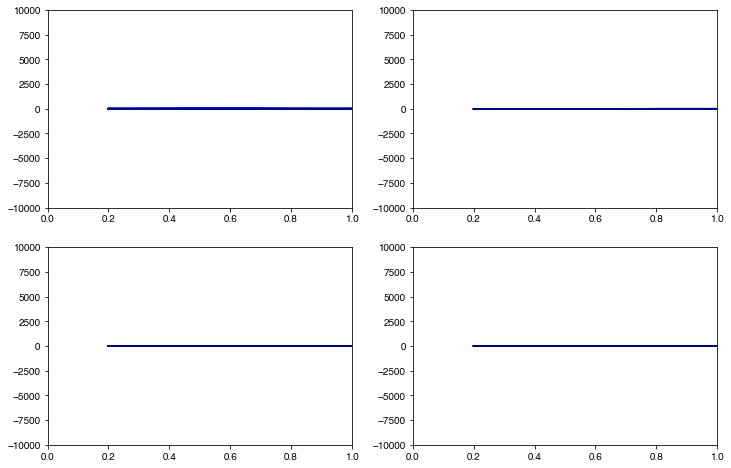

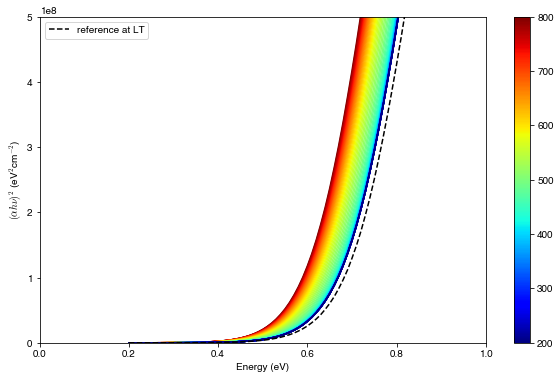

In [7]:
clusters = [empty, point, pair_1, pair_2, triplet_1]
model_ccts = main("ccts", clusters, gap_th=0.30, w_exp=10, verbose=False)
corr_fraction, corr_mc = ec_abs("ccts",clusters,model_ccts)